In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pli
import seaborn as sns
import os
import tensorflow as tf
from PIL import Image
import torch
from torch import nn
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
from sklearn.metrics import classification_report
from google.colab import drive
from torchvision import transforms
from torch.utils.data import ConcatDataset
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [2]:
drive.mount('/content/drive')
labels_path = "/content/drive/MyDrive/nih_chest_xray_subset/sample_labels.csv"
labels_df = pd.read_csv(labels_path)

Mounted at /content/drive


In [3]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [4]:
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [5]:
labels_df.shape

(5606, 11)

In [6]:
labels_df['Finding Labels'].value_counts()

,count
Finding Labels,
No Finding,3044
Infiltration,503
Effusion,203
Atelectasis,192
Nodule,144
...,...
Atelectasis|Emphysema|Infiltration|Nodule|Pneumothorax,1
Cardiomegaly|Effusion|Mass|Pneumothorax,1
Cardiomegaly|Edema|Infiltration|Nodule,1


In [7]:
data = []

for _, row in labels_df.iterrows():
    image_path = os.path.join('/content/drive/MyDrive/nih_chest_xray_subset/images', row['Image Index'])
    labels = row['Finding Labels'].split('|')
    data.append({'image_path': image_path, 'labels': labels})

print(data[:5])

[{'image_path': '/content/drive/MyDrive/nih_chest_xray_subset/images/00000013_005.png', 'labels': ['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax']}, {'image_path': '/content/drive/MyDrive/nih_chest_xray_subset/images/00000013_026.png', 'labels': ['Cardiomegaly', 'Emphysema']}, {'image_path': '/content/drive/MyDrive/nih_chest_xray_subset/images/00000017_001.png', 'labels': ['No Finding']}, {'image_path': '/content/drive/MyDrive/nih_chest_xray_subset/images/00000030_001.png', 'labels': ['Atelectasis']}, {'image_path': '/content/drive/MyDrive/nih_chest_xray_subset/images/00000032_001.png', 'labels': ['Cardiomegaly', 'Edema', 'Effusion']}]


In [8]:
num_class_1 = sum(["Infiltration" in r["labels"] for r in data])
print(num_class_1)

967


In [9]:
num_class_0 = sum(["Infiltration" not in r["labels"] for r in data])
print(num_class_0)

4639


The most frequent label is **"No Finding"**, with 3,044 occurrences, representing cases with no disease. Among the disease labels, **Infiltration** is the most prevalent, appearing 503 times as a standalone condition. Considering both standalone and combined occurrences, **Infiltration** appears a total of 967 times.

The analysis will focus on this label.

# TensorFlow Keras

In [10]:
def preprocess_item(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    return image, label

paths = [item['image_path'] for item in data]
labels = [1 if "Infiltration" in item["labels"] else 0 for item in data]


dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
# Maps the preprocess_item function over the dataset with parallel processing to improve speed
# (num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(lambda x, y: preprocess_item(x, y), num_parallel_calls=tf.data.AUTOTUNE)

dataset_nobatch = dataset
dataset = dataset.cache()

In [11]:
# Shuffle to improve your workout
dataset = dataset.shuffle(buffer_size=1000)

# Batch creation. Prefetch to load next batch in parallel
dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [12]:
for images, labels in dataset.take(1):
    print(f"Batch shape: {images.shape}, Labels shape: {labels.shape}")

Batch shape: (64, 224, 224, 3), Labels shape: (64,)


In [13]:
total_images = 0
for images, labels in dataset:
   total_images += images.shape[0]

print(f"Total_number_of: {total_images}")

Total_number_of: 5606


**Model Description**  
A binary classification model is defined using MobileNetV2 as the base, pretrained on ImageNet. The base model is used as a feature extractor with its weights frozen (trainable=False).

Key components include:  
- GlobalMaxPooling2D, which reduces spatial dimensions to a single vector and improves recognition of class 1 compared to GlobalAveragePooling2D.   
- A fully connected layer with 64 units and ReLU activation.
- An output layer with 1 unit and sigmoid activation for binary classification.  
- Optimizer: Adam, configured with a learning rate of 0.001.
- Loss function: Binary crossentropy, suitable for binary classification tasks.
- Metric: Accuracy, to evaluate the model’s performance.

In [33]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model_tf = tf.keras.Sequential([base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# GlobalMaxPooling2D: Loses some overall accuracy, but improves on class 1 recognition compared to GlobalAveragePooling2D
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [34]:
model_tf.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
dataset_size = len(dataset)

test_size = int(dataset_size * 0.2)
train_size = dataset_size - test_size

test_set = dataset.take(test_size)  # Top 20% for the test
train_set = dataset.skip(test_size)  # Remaining 80% for training

In [17]:
print(f"Dataset (batch): {dataset_size}")
print(f"Test set (batch): {test_size}")
print(f"Training set (batch): {train_size}")

Dataset (batch): 88
Test set (batch): 17
Training set (batch): 71


Initially, the model was trained for 4 epochs using a validation set, achieving the following results:

- Epoch 1: accuracy = 0.7468, loss = 1.1884, val_accuracy = 0.8867, val_loss = 0.3631
- Epoch 2: accuracy = 0.7985, loss = 0.5537, val_accuracy = 0.8535, val_loss = 0.4095
- Epoch 3: accuracy = 0.8184, loss = 0.4813, val_accuracy = 0.8066, val_loss = 0.4669
- Epoch 4: accuracy = 0.8278, loss = 0.4477, val_accuracy = 0.8672, val_loss = 0.3802
  
The validation accuracy and loss did not show a consistent improvement  fluctuating across epochs.  
Given these results, the following adjustments were made:  

- **Reduced Epochs**: Training was limited to a single epoch to avoid overfitting and computational inefficiencies.
- **Simplified Dataset Split**: The dataset was divided into training and test sets only, maximizing the data available for training.

In [18]:
history = model_tf.fit(train_set, epochs=2)

Epoch 1/2
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.7574 - loss: 1.4156
Epoch 2/2
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8372 - loss: 0.4396


In [19]:
test_loss, test_accuracy = model_tf.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8573 - loss: 0.4019
Test Loss: 0.39950835704803467, Test Accuracy: 0.8584558963775635


In [20]:
y_true = []
y_pred = []
for images, labels in test_set:
    preds = model_tf.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

print(classification_report(y_true, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       944
           1       1.00      0.02      0.04       144

    accuracy                           0.87      1088
   macro avg       0.94      0.51      0.49      1088
weighted avg       0.89      0.87      0.81      1088



This is due to the imbalance of the dataset the model almost always predicts 0, largely failing to detect most of the positive cases.  
**Precision for Class 1**:  
1.00 indicates that when the model predicts "Infiltration", it is correct 100% of the time.  
**Recall for Class 1**:  
0.02 indicates that the model only identifies 2% of actual "Infiltration" cases.

# Pytorch

In [29]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CovNet(nn.Module):
  def __init__(self, channels, classes):
    super(CovNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=(5,5), padding='same')
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding='same')
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(in_features=64*56*56, out_features=128)
    self.relu3 = nn.ReLU()

    self.fc2 = nn.Linear(in_features=128, out_features=classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = self.maxpool1(x)
    x = nn.functional.relu(self.conv2(x))
    x = self.maxpool2(x)
    x = self.flatten(x)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)
    return x

In [ ]:
model = CovNet(channels=3, classes=2).to(device)

NameError: name 'CovNet' is not defined

In [ ]:
learning_rate = 0.001
num_epochs = 10
num_classes = 2
batch_size = 64
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ChestXRayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of file paths to images.
            labels (list): List of labels corresponding to the images.
            transform (callable, optional): Transform to be applied on an image.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        # Get the label
        label = self.labels[idx]

        return image, label

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),         # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Example CSV file containing image paths and labels
csv_file = '/content/drive/MyDrive/nih_chest_xray_subset/sample_labels.csv'  # Replace with your file path
labels_df = pd.read_csv(csv_file)

# Extract image paths and labels
data = []
labels = []  # Separate list for labels

for _, row in labels_df.iterrows():
    image_path = os.path.join('/content/drive/MyDrive/nih_chest_xray_subset/images', row['Image Index'])
    label = 1 if "Infiltration" in row['Finding Labels'].split('|') else 0  # Binary label
    data.append(image_path)  # Append only the image path
    labels.append(label)  # Append the binary label

# Split into train, test, and validation sets
train_size = int(0.8 * len(data))
test_size = int(0.2 * len(data))


train_paths, train_labels = data[:train_size], labels[:train_size]
test_paths, test_labels = data[train_size:train_size+test_size], labels[train_size:train_size+test_size]


# Create datasets
train_dataset = ChestXRayDataset(train_paths, train_labels, transform=transform)
test_dataset = ChestXRayDataset(test_paths, test_labels, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import time
import copy

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    import time
    import copy
    import torch

    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Dynamically determine dataset size
            dataset_size = sum(1 for _ in dataloaders[phase])

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward pass and optimization in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    history_dict = {'train_loss': train_loss_history, 'train_accuracy': train_acc_history,
                    'test_loss': test_loss_history, 'test_accuracy': test_acc_history}
    return model, history_dict


In [ ]:
train_model(model,
            {'train':train_loader},
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=5)

Epoch 1/5


KeyboardInterrupt: 

## **TEST TUTORIAL**

In [ ]:
dataloaders ={'train': train_loader, 'valid': test_loader, 'test': test_loader}

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.layer1 = self.ConvModule(in_features=3, out_features=64)      #16,16
        self.layer2 = self.ConvModule(in_features=64, out_features=128)    #8,8
        self.layer3 = self.ConvModule(in_features=128, out_features=256)   #4,4
        self.layer4 = self.ConvModule(in_features=256, out_features=512)   #2,2

        # Calculate the correct input size for the first linear layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(56*56*512, 1024), # Adjusted input size
                                        nn.ReLU(),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,2), # Adjusted to 2 for binary classification
                                        nn.Softmax(dim=1)) # Added dim=1 for softmax

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x

    def ConvModule(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding="same"),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )

In [ ]:
learning_rate = 0.001
num_epochs = 35
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    history_dict = {'train_loss':train_loss_history, 'train_accuracy':train_acc_history,
                    'test_loss':test_loss_history, 'test_accuracy':test_acc_history}
    return model, history_dict

In [ ]:
model, hist = train_model(model,
            dataloaders,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=5)

Epoch 1/5


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x100352 and 2048x1024)

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, input_size=(3, 224, 224), num_classes=2):
        super(CustomCNN, self).__init__()

        # Define convolutional layers using ConvModule
        self.layer1 = self.ConvModule(3, 64)      # Output size after pooling: 112x112
        self.layer2 = self.ConvModule(64, 128)   # Output size after pooling: 56x56
        self.layer3 = self.ConvModule(128, 256)  # Output size after pooling: 28x28
        self.layer4 = self.ConvModule(256, 512)  # Output size after pooling: 14x14

        # Dynamically calculate flattened size
        flattened_size = self._get_flattened_size(input_size)

        # Define classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x

    def ConvModule(self, in_features, out_features):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def _get_flattened_size(self, input_size):
        """Utility to compute flattened size after convolutions."""
        with torch.no_grad():
            x = torch.zeros(1, *input_size)
            x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
            return x.numel()

# Example Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(input_size=(3, 224, 224), num_classes=2).to(device)


# Set up training parameters
learning_rate = 0.001
num_epochs = 35
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, optimizer
model = CustomCNN(input_size=(3, 224, 224), num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_model(model, dataloaders, criterion, optimizer, num_epochs, device):
    """
    Train the model and compute accuracy, precision, recall, and F1-score.

    Args:
        model (nn.Module): The PyTorch model to train.
        dataloaders (dict): Dictionary containing 'train' and 'test' DataLoaders.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to use (CPU/GPU).

    Returns:
        model (nn.Module): Trained model with the best weights.
        metrics (dict): Dictionary containing loss and detailed metrics (accuracy, precision, recall, F1-score).
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize dictionaries to store metrics
    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_precision': [],
        'test_recall': [],
        'test_f1': [],
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            all_labels = []
            all_preds = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            # Compute loss
            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            # Compute metrics
            epoch_accuracy = accuracy_score(all_labels, all_preds)
            epoch_precision = precision_score(all_labels, all_preds, average='weighted')
            epoch_recall = recall_score(all_labels, all_preds, average='weighted')
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, "
                  f"Acc: {epoch_accuracy:.4f}, "
                  f"Precision: {epoch_precision:.4f}, "
                  f"Recall: {epoch_recall:.4f}, "
                  f"F1: {epoch_f1:.4f}")

            # Store metrics
            if phase == 'train':
                metrics['train_loss'].append(epoch_loss)
                metrics['train_accuracy'].append(epoch_accuracy)
                metrics['train_precision'].append(epoch_precision)
                metrics['train_recall'].append(epoch_recall)
                metrics['train_f1'].append(epoch_f1)
            else:
                metrics['test_loss'].append(epoch_loss)
                metrics['test_accuracy'].append(epoch_accuracy)
                metrics['test_precision'].append(epoch_precision)
                metrics['test_recall'].append(epoch_recall)
                metrics['test_f1'].append(epoch_f1)

                # Save the best model
                if epoch_accuracy > best_acc:
                    best_acc = epoch_accuracy
                    best_model_wts = copy.deepcopy(model.state_dict())

    print('-' * 10)
    print(f'Training complete. Best test accuracy: {best_acc:.4f}')

    # Load the best weights
    model.load_state_dict(best_model_wts)
    return model, metrics

In [ ]:
dataloaders = {'train': train_loader, 'test': test_loader}
model, metrics = train_model(model, dataloaders, criterion, optimizer, num_epochs=5, device=device)

Epoch 1/5
----------
Train Loss: 0.4506, Acc: 0.8278, Precision: 0.7355, Recall: 0.8278, F1: 0.7624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 0.5088, Acc: 0.7948, Precision: 0.6317, Recall: 0.7948, F1: 0.7040
Epoch 2/5
----------
Train Loss: 0.4223, Acc: 0.8359, Precision: 0.8628, Recall: 0.8359, F1: 0.7614


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 0.5216, Acc: 0.7948, Precision: 0.6317, Recall: 0.7948, F1: 0.7040
Epoch 3/5
----------
Train Loss: 0.4137, Acc: 0.8359, Precision: 0.8628, Recall: 0.8359, F1: 0.7614
Test Loss: 0.5074, Acc: 0.7948, Precision: 0.7348, Recall: 0.7948, F1: 0.7056
Epoch 4/5
----------
Train Loss: 0.4211, Acc: 0.8336, Precision: 0.7683, Recall: 0.8336, F1: 0.7682


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 0.5339, Acc: 0.7948, Precision: 0.6317, Recall: 0.7948, F1: 0.7040
Epoch 5/5
----------
Train Loss: 0.3982, Acc: 0.8381, Precision: 0.8167, Recall: 0.8381, F1: 0.7699
Test Loss: 0.5381, Acc: 0.7948, Precision: 0.6317, Recall: 0.7948, F1: 0.7040
----------
Training complete. Best test accuracy: 0.7948


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


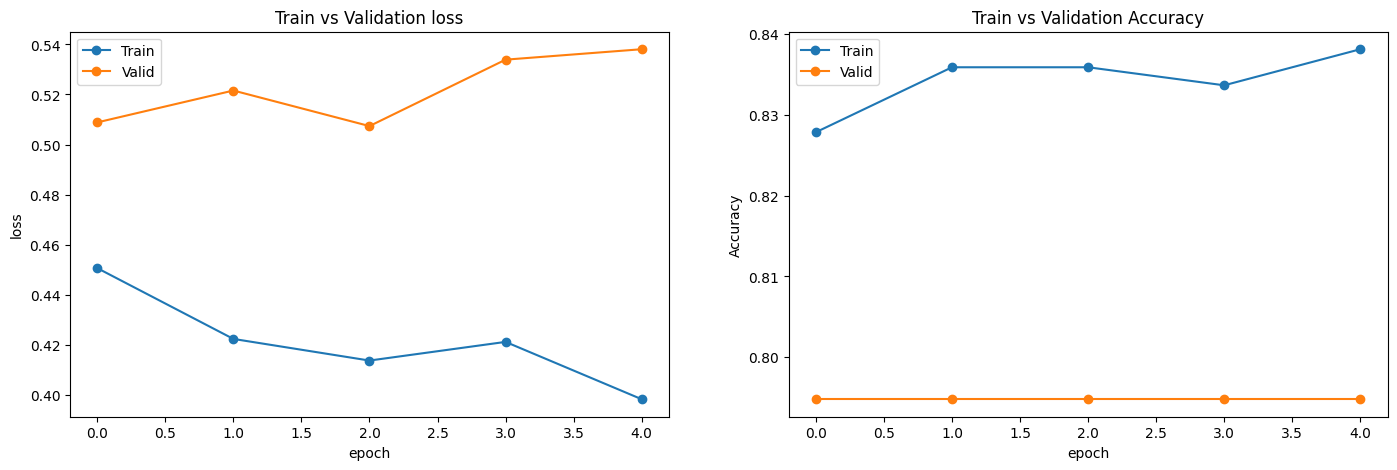

In [ ]:
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(metrics['train_loss'],'-o')
plt.plot(metrics['test_loss'],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation loss')

plt.subplot(122)
plt.plot(metrics['train_accuracy'],'-o')
plt.plot(metrics['test_accuracy'],'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation Accuracy')


plt.show()

In [ ]:
weights = model.state_dict()
torch.save(weights, 'weights.pth')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, device):
    """
    Compute and plot the confusion matrix for the model's predictions.

    Args:
        model (nn.Module): Trained PyTorch model.
        dataloader (DataLoader): Dataloader for test data.
        device (torch.device): Device to run the computations on (CPU/GPU).
    """
    model.eval()  # Set the model to evaluation mode

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Store true labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(len(cm))))

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


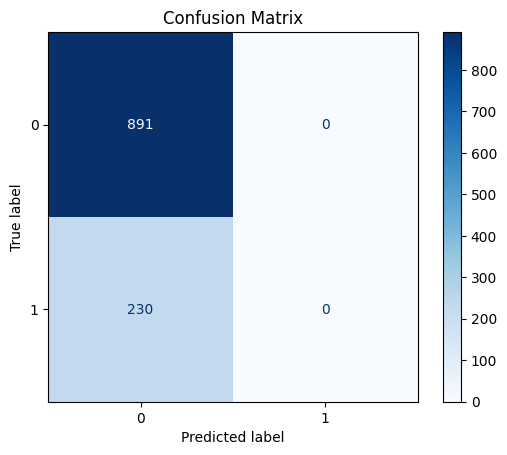

In [ ]:
plot_confusion_matrix(model, test_loader, device)

# PYTORCH DATA AUGMENTATION (Scratch Model)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms

# Definizione del Dataset personalizzato
class ChestXRayDataset(Dataset):
    def __init__(self, data, transform=None):  # Updated initialization
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]['image_path']
        label = 1 if "Infiltration" in self.data[idx]['labels'] else 0 #label is extracted here
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Trasformazioni con Data Augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Trasformazioni base (senza augmentation)
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset originale con trasformazioni base
base_dataset = ChestXRayDataset(data, transform=base_transforms) #updated with the new arguments

# Dataset augmentato solo per la classe 1
class_1_data = [item for item in data if "Infiltration" in item["labels"]]
augmented_dataset = ChestXRayDataset(class_1_data, transform=augmentation_transforms) #updated with the new arguments

# Combina il dataset originale e quello augmentato
combined_dataset = ConcatDataset([base_dataset, augmented_dataset])

# Split in train e test set
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verifica delle dimensioni dei DataLoader
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Train Dataset Size: 5258
Test Dataset Size: 1315


In [ ]:
dataloaders = {'train': train_loader, 'test': test_loader}
model_augmented, metrics_augmented = train_model(model, dataloaders, criterion, optimizer, num_epochs=5, device=device)

Epoch 1/5
----------
Train Loss: 0.4535, Acc: 0.8189, Precision: 0.8321, Recall: 0.8189, F1: 0.7965
Test Loss: 0.4407, Acc: 0.8106, Precision: 0.8097, Recall: 0.8106, F1: 0.7938
Epoch 2/5
----------
Train Loss: 0.4003, Acc: 0.8406, Precision: 0.8555, Recall: 0.8406, F1: 0.8232
Test Loss: 0.4340, Acc: 0.8395, Precision: 0.8634, Recall: 0.8395, F1: 0.8195
Epoch 3/5
----------
Train Loss: 0.3938, Acc: 0.8382, Precision: 0.8480, Recall: 0.8382, F1: 0.8221
Test Loss: 0.4106, Acc: 0.8304, Precision: 0.8492, Recall: 0.8304, F1: 0.8095
Epoch 4/5
----------
Train Loss: 0.3692, Acc: 0.8509, Precision: 0.8649, Recall: 0.8509, F1: 0.8360
Test Loss: 0.4589, Acc: 0.7977, Precision: 0.7931, Recall: 0.7977, F1: 0.7947
Epoch 5/5
----------
Train Loss: 0.3610, Acc: 0.8528, Precision: 0.8605, Recall: 0.8528, F1: 0.8406
Test Loss: 0.4352, Acc: 0.8350, Precision: 0.8625, Recall: 0.8350, F1: 0.8127
----------
Training complete. Best test accuracy: 0.8395


In [ ]:
weights_augmented = model_augmented.state_dict()
torch.save(weights_augmented, 'weights_augmented.pth')

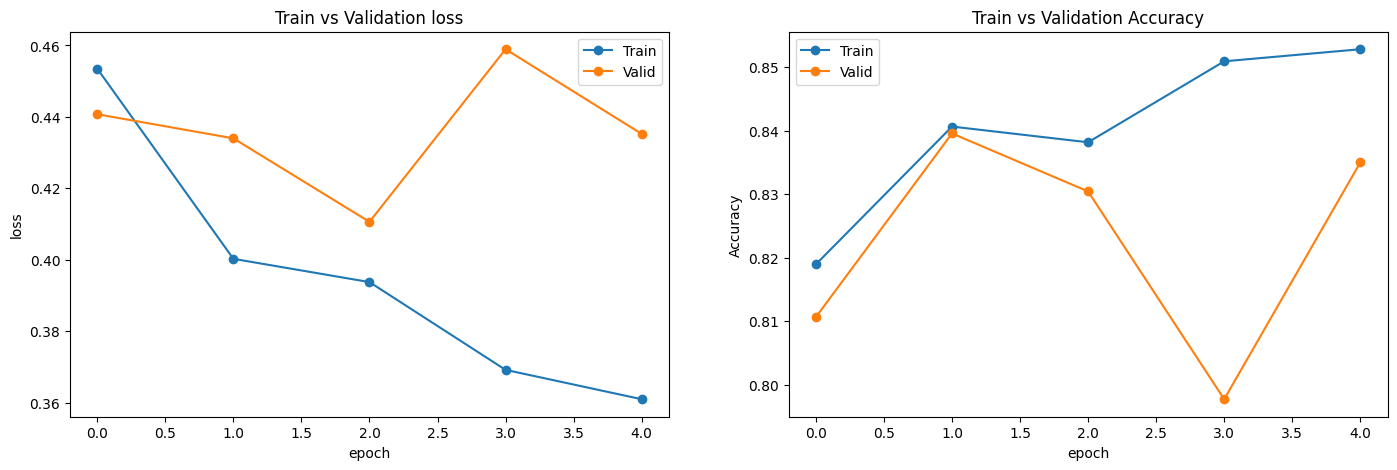

In [ ]:
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(metrics_augmented['train_loss'],'-o')
plt.plot(metrics_augmented['test_loss'],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation loss')

plt.subplot(122)
plt.plot(metrics_augmented['train_accuracy'],'-o')
plt.plot(metrics_augmented['test_accuracy'],'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation Accuracy')


plt.show()

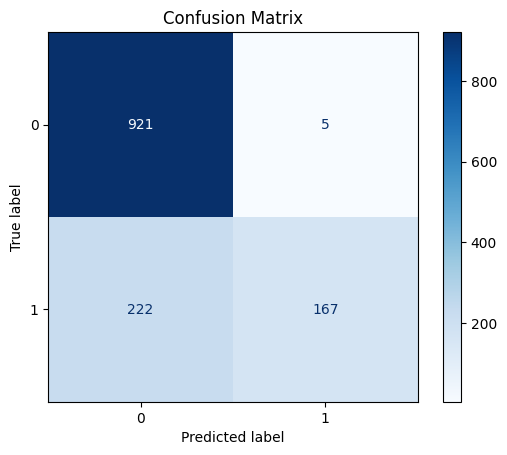

In [ ]:
plot_confusion_matrix(model_augmented, test_loader, device)

# PYTORCH mobilenet_v2

In [21]:
class ChestXRayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]['image_path']
        label = 1 if "Infiltration" in self.data[idx]['labels'] else 0
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [22]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

dataset_pytorch = ChestXRayDataset(data, transform=transform)
train_size = int(0.8 * len(dataset_pytorch))
test_size = len(dataset_pytorch) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset_pytorch, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Model Description**  
A binary classification model is defined using MobileNetV2 as the base, pretrained on ImageNet. The base model is used as a feature extractor with its weights retained from the pretraining.

Key components include:
  
- A linear classifier, replacing the original output layer, with a single output logit for binary classification.
- Loss function: BCEWithLogitsLoss, which combines sigmoid activation and binary crossentropy for stable handling of logits.
- Optimizer: Adam, configured with a learning rate of 0.001.

In [23]:
# Pre-trained model
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 1)  # Binary output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 181MB/s]


In [24]:
# Training
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/3, Loss: 0.4612
Epoch 2/3, Loss: 0.4437
Epoch 3/3, Loss: 0.4189


In [26]:
# Validation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.4).int()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Test Classification Report:")
print(classification_report(y_true, y_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       923
           1       0.20      0.01      0.01       199

    accuracy                           0.82      1122
   macro avg       0.51      0.50      0.46      1122
weighted avg       0.71      0.82      0.74      1122



The results highlight the significant impact of dataset imbalance on the model's performance.

- **Precision for Class 1**:  
  With a precision of **0.20**, the model is correct 20% of times when it predicts class 1.

- **Recall for Class 1**:  
  A recall of 0.01 indicates that the model correctly identifies only 1% of actual positive cases.

The overall accuracy (83%) and the high performance on **class 0** are driven by the dataset imbalance, as the majority of the samples belong to this class.

# Data Augmentation and Balancing for Class 1  
This section implements data augmentation techniques to balance the dataset and improve the model's ability to detect positive cases (Class 1 - "Infiltration"). Augmentation is applied selectively to Class 1 images, and the augmented data is combined with the original dataset for training.

# TensorFlow Keras (with DATA AUGMENTATION)

In [36]:
# Filter only class 1 images
class_1_data = [item for item in data if "Infiltration" in item["labels"]]
class_1_paths = [item['image_path'] for item in class_1_data]
class_1_labels = [1] * len(class_1_data)

class_1_dataset = tf.data.Dataset.from_tensor_slices((class_1_paths, class_1_labels))

def augment_image(image):
    # Augmentation operations
    image = tf.image.random_flip_left_right(image)  # Horizontal Flip
    image = tf.image.random_flip_up_down(image)    # Vertical Flip
    image = tf.image.rot90(image, k=np.random.randint(1, 4))  # Random rotation
    return image

# Preprocessing and augmentation function
def preprocess_and_augment(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224]) / 255.0
    image = augment_image(image)
    return image, label

# Augmentation dataset for class 1 (each original image produces an augmented image)
augmented_class_1_dataset = class_1_dataset.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
print(len(augmented_class_1_dataset))

967


In [37]:
print(len(augmented_class_1_dataset))
print(len(dataset_nobatch))

# Combine original and augmented images of class 1
combined_class_1_dataset = dataset_nobatch.concatenate(augmented_class_1_dataset)
print(len(combined_class_1_dataset))

967
5606
6573


In [38]:
# Apply shuffle and batching to the combined dataset
combined_class_1_dataset = combined_class_1_dataset.shuffle(buffer_size=1000)
combined_class_1_dataset = combined_class_1_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [39]:
dataset_size = len(combined_class_1_dataset)
test_size = int(dataset_size * 0.2)
train_size = dataset_size - test_size

test_set = combined_class_1_dataset.take(test_size)  # Top 20% for the test
train_set = combined_class_1_dataset.skip(test_size)  # Remaining 80% for training

In [40]:
print(f"Dataset totale: {dataset_size}")
print(f"Test set: {test_size}")
print(f"Training set: {train_size}")

Dataset totale: 103
Test set: 20
Training set: 83


In [41]:
model_tf.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
history = model_tf.fit(train_set, epochs=3)

Epoch 1/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 214ms/step - accuracy: 0.7673 - loss: 0.7846
Epoch 2/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.7819 - loss: 0.5546
Epoch 3/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.7822 - loss: 0.5086


In [44]:
test_loss, test_accuracy = model_tf.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.4592 - loss: 0.7406
Test Loss: 0.7364811301231384, Test Accuracy: 0.4585937559604645


In [46]:
y_true = []
y_pred = []

for images, labels in test_set:
    preds = model_tf.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

thresholds = [0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_pred_class = (y_pred > threshold).astype(int)
    print(f"Classification report for threshold = {threshold}")
    print(classification_report(y_true, y_pred_class))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Classification report for threshold = 0.3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1111
           1       0.13      1.00      0.23       169

    accuracy                      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The results highlight how varying the threshold for classification impacts the model's performance, particularly in addressing the class imbalance. At a low threshold of 0.3, the model predicts nearly all samples as Class 1, leading to a recall of 1.0 for Class 1 but a precision of 0.13, as many false positives are generated. As the threshold increases to 0.4, the recall for Class 1 remains high (0.98), but the precision for Class 0 slightly improves. At the standard threshold of 0.5, the balance shifts: the model identifies fewer Class 1 samples, achieving a recall of 0.82 but with better precision for both classes. However, the overall accuracy remains low (43%) due to misclassifications. At a higher threshold of 0.6, the model predicts most samples as Class 0, achieving high precision (0.89) and recall (0.85) for Class 0, but severely underperforming on Class 1, with a recall of just 0.27. These results illustrate the trade-off between precision and recall for the minority class (Class 1) and emphasize the need for careful threshold tuning and addressing the dataset imbalance to improve performance.

# Pytorch (with DATA AUGMENTATION)

In [53]:
# Transformations with Data Augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal Flip
    transforms.RandomVerticalFlip(p=0.5),    # Vertical Flip
    transforms.RandomRotation(degrees=45),   # Random rotation within 45°
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Random Crop
    transforms.ToTensor()])

# Basic transformations (without augmentation)
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

# Original dataset with basic transformations
base_dataset = ChestXRayDataset(data, transform=base_transforms)

In [54]:
# Dataset augmented for class 1 only
class_1_data = [item for item in data if "Infiltration" in item["labels"]]
augmented_dataset = ChestXRayDataset(class_1_data, transform=augmentation_transforms)
print(len(augmented_dataset))

# Combine the original and augmented dataset
combined_dataset = ConcatDataset([base_dataset, augmented_dataset])

967


In [55]:
# DataLoader
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [56]:
# Pre-trained model
weights = MobileNet_V2_Weights.DEFAULT  # Use latest weights
model = mobilenet_v2(weights=weights)
model.classifier[1] = nn.Linear(model.last_channel, 1)
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 170MB/s]


In [57]:
# Training loop
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/4, Loss: 0.4235
Epoch 2/4, Loss: 0.3753
Epoch 3/4, Loss: 0.3526
Epoch 4/4, Loss: 0.3350


In [58]:
# Evaluation on validation and test sets with multiple thresholds
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

thresholds = [0.3, 0.4, 0.5, 0.6]
for threshold in thresholds:
    y_pred_class = (y_pred > threshold).astype(int)
    print(f"Classification report for threshold = {threshold}")
    print(classification_report(y_true, y_pred_class))

Classification report for threshold = 0.3
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       936
           1       0.48      0.83      0.60       379

    accuracy                           0.69      1315
   macro avg       0.69      0.73      0.67      1315
weighted avg       0.78      0.69      0.70      1315

Classification report for threshold = 0.4
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       936
           1       0.54      0.74      0.62       379

    accuracy                           0.74      1315
   macro avg       0.71      0.74      0.71      1315
weighted avg       0.78      0.74      0.75      1315

Classification report for threshold = 0.5
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       936
           1       0.62      0.64      0.63       379

    accuracy                           0.78      1315
  

In a medical context, where false negatives (failing to detect the disease) are far more critical than false positives, you should prioritize recall over precision. A higher recall ensures that most cases of the disease (Class 1) are identified, even if it means increasing false positives. Based on the results, we prefer a threshold of 0.3, as it maximizes recall (83%) while maintaining acceptable precision (48%). However, this model is not yet usable in practice; more data is needed to improve its robustness and reliability.